In [96]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

References: 
- https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=GuE5BqICAne2
- https://colab.research.google.com/drive/1FT2ppZsOQx2HdPJ799ygW8EeTcVUwtAD
- https://huggingface.co/docs/transformers/model_doc/bert

## Load data

In [97]:
reports_df = pd.read_csv("nlp_reports_data.csv")

In [98]:
reports_df.head()

,Unnamed: 0,id,findings,impression,full-text,label
0,0,3103,Cardiomediastinal silhouette stable and unrema...,No acute cardiopulmonary abnormality..,Cardiomediastinal silhouette stable and unrema...,abnormal
1,1,588,The heart is normal in size and contour. There...,No acute cardiopulmonary abnormalities.,The heart is normal in size and contour. There...,normal
2,2,1332,NaN,Heart size is upper normal. Tortuous and calci...,Heart size is upper normal. Tortuous and calc...,abnormal
3,3,3749,Lungs are clear bilaterally. Cardiac and media...,No acute cardiopulmonary abnormality.,Lungs are clear bilaterally. Cardiac and media...,normal
4,4,3857,The cardiomediastinal silhouette is within nor...,1. No acute radiographic cardiopulmonary process.,The cardiomediastinal silhouette is within nor...,normal


Abnormal: 2469
Normal: 1486


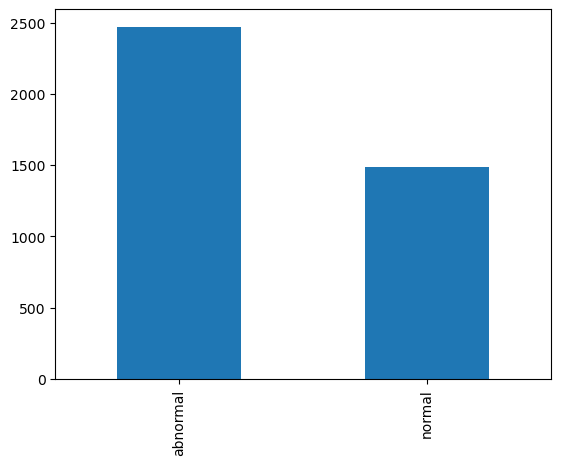

In [99]:
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
label_counts.plot.bar();

In [72]:
# fix seed
np.random.seed(2021)

train_df, test_df = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)

Compare the distribution of labels in the full dataset to the distribution in the test dataset. The distributions are similar.

Test set size: 594
Abnormal: 371
Normal: 223


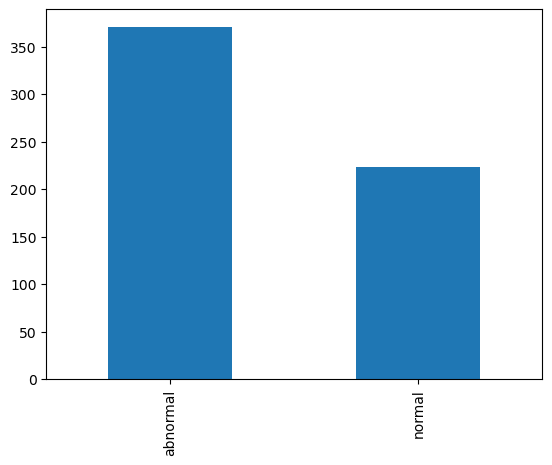

In [73]:
print('Test set size:', test_df.shape[0])
test_counts = test_df.label.value_counts()
print('Abnormal:', test_counts['abnormal'])
print('Normal:', test_counts['normal'])
test_counts.plot.bar();

Plot text length of each report

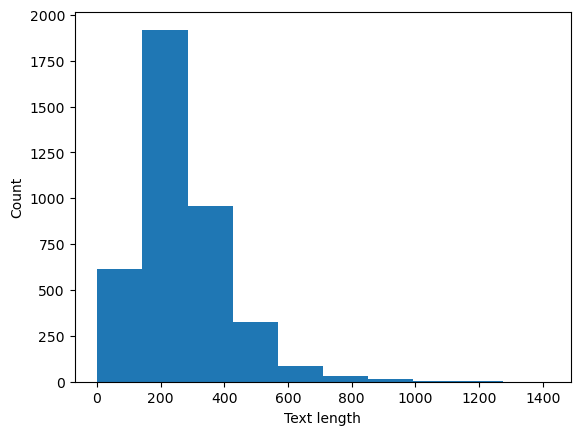

1417.0

In [74]:
reports_df["text length"] = reports_df["full-text"].str.len()
plt.hist(x=reports_df["text length"])
plt.xlabel("Text length")
plt.ylabel("Count")
plt.show()
np.percentile(reports_df["text length"], 100)

In [75]:
MAX_LEN = 450

In [76]:
def pad_seq(input_lst, padding_val):
    '''
    Parameters
        input_lst: list of lists to pad
        padding_val: list length
    Return
        new_input_lst: input_lst with lengths truncated or padded so that they're equal to the padding_val
    '''
    new_input_lst = []
    for lst in input_lst:
        if len(lst) > padding_val:
            #Truncate
            lst = lst[:padding_val] 
        elif len(lst) < padding_val:
            #Pad
            lst.extend([0] * (padding_val - len(lst)))
            
        new_input_lst.append(lst)
            
    return new_input_lst   

In [77]:
def prep_data(df):
    '''
    Parameters
        df: data
    Return
        padded_input_ids: array of integers identifying input tokens to their index number in the BERT tokenizer vocabulary
        attention_masks: array of 1s and 0s (1s for input tokens, 0s for padding tokens)
        labels: array of 1s and 0s (for our data - 1s mean abnormal, 0s mean normal)
    '''
    sentences = df["full-text"]

    # Add special tokens at the beginning and end of each sentence
    sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
    labels = df.label.values
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    
    # Convert the tokens to their index numbers in the BERT vocabulary
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    padded_input_ids = pad_seq(input_ids, padding_val = MAX_LEN) 
    padded_labels = labels
    
    # Create attention masks
    attention_masks = []

    for seq in padded_input_ids:
        seq_mask= [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
        
    labels = np.array([0 if x=="normal" else 1 for x in padded_labels])
    
    return padded_input_ids, attention_masks, labels

## Train model

In [78]:
padded_input_ids, attention_masks, padded_labels = prep_data(train_df[:100]) #just do first 100

In [79]:
# Split data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(padded_input_ids, padded_labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, padded_input_ids,
                                             random_state=2018, test_size=0.1)

In [80]:
# Convert data into torch tensors

train_inputs = torch.tensor(train_inputs, dtype=torch.int64)
validation_inputs = torch.tensor(validation_inputs, dtype=torch.int64)
train_labels = torch.tensor(train_labels, dtype=torch.int64)
validation_labels = torch.tensor(validation_labels, dtype=torch.int64)
train_masks = torch.tensor(train_masks, dtype=torch.int64)
validation_masks = torch.tensor(validation_masks, dtype=torch.int64)

/var/folders/yg/cmnxf1bn3sd_4qxy18q6kdbw0000gn/T/ipykernel_19324/3829265911.py:7: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_masks = torch.tensor(train_masks, dtype=torch.int64)
/var/folders/yg/cmnxf1bn3sd_4qxy18q6kdbw0000gn/T/ipykernel_19324/3829265911.py:8: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  validation_masks = torch.tensor(validation_masks, dtype=torch.int64)


In [81]:
# Select a batch size for training.
batch_size = 32

# Create an iterator of our data with torch DataLoader. 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [82]:
# Load BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [83]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


In [84]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [86]:
t = [] 
train_loss_set = []
epochs = 4

for _ in trange(epochs, desc="Epoch"):

    # Training

    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())  
        
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        print(eval_loss, ", ", eval_accuracy)
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
torch.save(model.state_dict(), 'bert_reports_model.pt')

Epoch:   0%|                                              | 0/4 [00:00<?, ?it/s]

Train loss: 0.6815311908721924
0 ,  0


Epoch:  25%|█████████▎                           | 1/4 [12:03<36:09, 723.04s/it]

Validation Accuracy: 0.6
Train loss: 0.5750696063041687
0 ,  0


Epoch:  50%|██████████████████▌                  | 2/4 [23:53<23:50, 715.46s/it]

Validation Accuracy: 0.7
Train loss: 0.5726120372613271
0 ,  0


Epoch:  75%|███████████████████████████▊         | 3/4 [35:38<11:50, 710.85s/it]

Validation Accuracy: 0.8
Train loss: 0.43163002530733746
0 ,  0


Epoch: 100%|█████████████████████████████████████| 4/4 [47:19<00:00, 709.88s/it]

Validation Accuracy: 0.8


Plot training loss over every batch

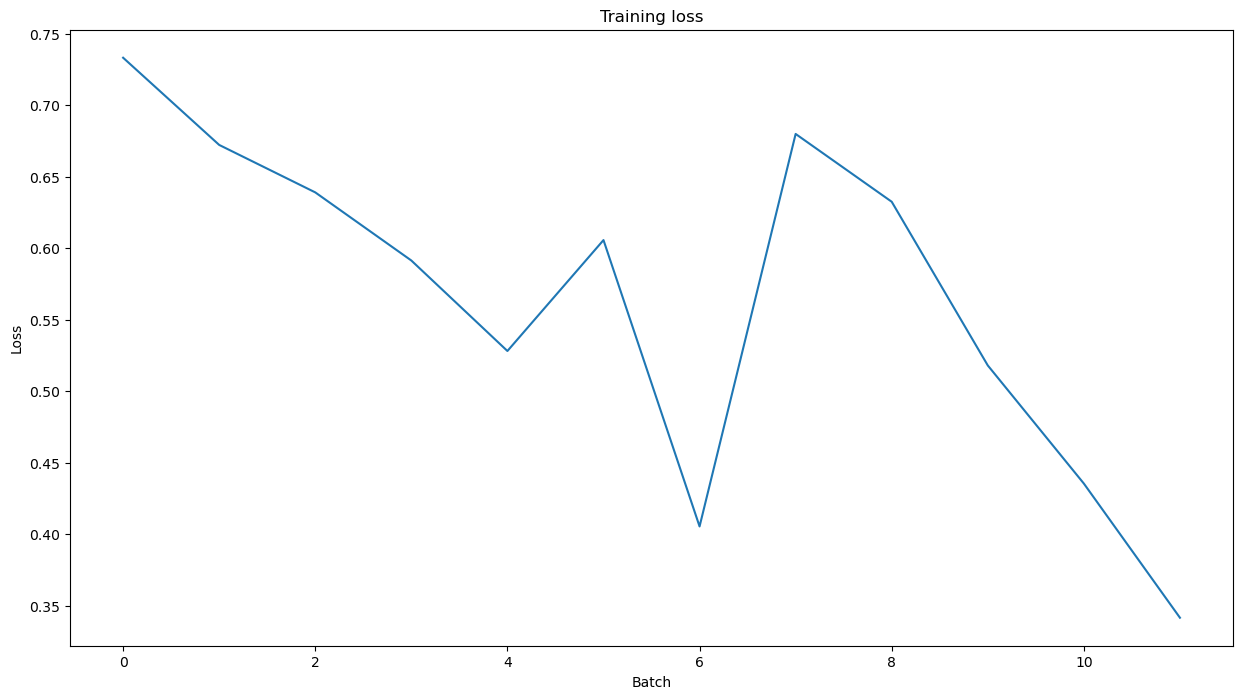

In [87]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Test and evaluate model

In [88]:
test_padded_input_ids, test_attention_masks, test_padded_labels = prep_data(test_df)

In [89]:
prediction_inputs = torch.tensor(test_padded_input_ids, dtype=torch.int64)
prediction_masks = torch.tensor(test_attention_masks, dtype=torch.int64)
prediction_labels = torch.tensor(test_labels_int, dtype=torch.int64)
  
batch_size = 32  

/var/folders/yg/cmnxf1bn3sd_4qxy18q6kdbw0000gn/T/ipykernel_19324/3093415169.py:2: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  prediction_masks = torch.tensor(test_attention_masks, dtype=torch.int64)


In [90]:
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [91]:
# Prediction on test set

model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

Evaluate a final score for each batch

In [92]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

In [93]:
matthews_set

[0.5633234713140696,
 0.5555555555555556,
 0.3333333333333333,
 0.45693676673168776,
 0.3394221166510653,
 0.19377278632539327,
 0.3216337604513384,
 0.28365431446558775,
 0.38297084310253526,
 0.23186944788008415,
 0.23186944788008415,
 0.7848566748139434,
 0.5606119105813882,
 0.38297084310253526,
 0.17054221752815663,
 0.17054221752815663,
 0.38331077069024155,
 0.0,
 0.2711630722733202]

Evaluate a final score for the entire test dataset

In [94]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [95]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.3774431377609275